# Golden Task: Build a spam filter using NLP and machine learning to identify and filter out spam emails

Develop a robust Spam Email Filter using Natural Language Processing (NLP)
techniques and machine learning algorithms. The goal is to create an intelligent
system capable of accurately classifying emails as either spam or legitimate
(ham) based on their content and linguistic features.

In [1]:
# Import libraries
import string
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import warnings
import plotly.express as px
import string
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.metrics import roc_curve, roc_auc_score,auc
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
data_path = "/kaggle/input/spam-email-dataset/emails.csv"
data = pd.read_csv(data_path)

In [4]:
spam_df = data.copy()
spam_df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [5]:
spam_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


In [6]:
spam_df.describe().T

,count,mean,std,min,25%,50%,75%,max
spam,5728.0,0.238827,0.426404,0.0,0.0,0.0,0.0,1.0


In [7]:
spam_df.dtypes

text    object
spam     int64
dtype: object

In [8]:
len(spam_df['text'].unique())

5695

In [9]:
#Check Null values
spam_df.isnull().sum()

text    0
spam    0
dtype: int64

In [10]:
#To check if there are any missing values
is_any_missing_data=spam_df.isna().any().any()
is_any_missing_data

False

In [11]:
spam_df.duplicated().sum()

33

In [12]:
#Fetch all duplicate values
duplicate=spam_df[spam_df.duplicated(keep='last')]
duplicate.head()

,text,spam
1417,"Subject: day off tuesday stinson , i would l...",0
1508,Subject: re : enron weather research good aft...,0
1532,Subject: schedule and more . . dr . kaminski ...,0
1667,"Subject: re : summer work . . jinbaek , this...",0
1749,"Subject: term paper dr . kaminski , attached...",0


In [13]:
#Remove Duplicate Records
spam_df.drop_duplicates(inplace=True)
spam_df.duplicated().sum()

0

In [14]:
# Rename names columns
spam_df=spam_df.rename(columns={'spam':'label'})

In [15]:
spam_df["length"] = spam_df["text"].apply(len)
spam_df.sort_values(by='length', ascending=False).head(3)

,text,label,length
2650,Subject: from the enron india newsdesk - april...,0,43952
1380,Subject: from the enron india newsdesk - april...,0,43937
2338,Subject: from the enron india newsdesk - april...,0,31055


In [16]:
counts = spam_df['label'].value_counts().reset_index()
counts.columns = ['Label', 'Count']
# Create a bar plot using Plotly Express
fig = px.bar(counts, x='Label', y='Count', color='Label')
fig.update_layout(title='Number of Spam and Ham Emails', xaxis_title='Label', yaxis_title='Count')
fig.update_xaxes(tickvals=[0, 1], ticktext=['Ham', 'Spam'])
fig.show()

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

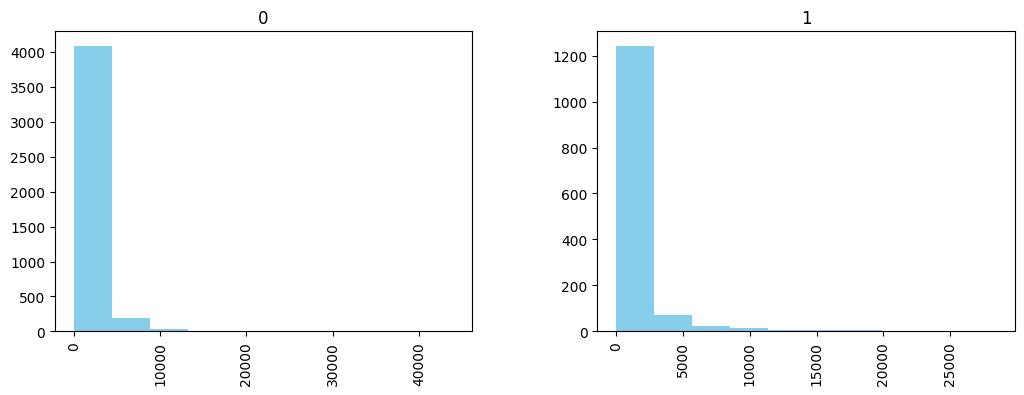

In [17]:
spam_df.hist(column = 'length', by ='label',figsize=(12,4), bins = 10,color='skyblue')

In [18]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [19]:
def preprocess_text(text):
    # Remove punctuation
    no_punctuation = ''.join([char for char in text if char not in string.punctuation])

    # Lowercase the text
    no_punctuation_lower = no_punctuation.lower()

    # Tokenize the text into words
    words = nltk.word_tokenize(no_punctuation_lower)

    # Remove stopwords and non-alphabetic characters, and lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word.lower() not in stopwords.words('english') and word.isalpha()]

    # Join the lemmatized words back into a sentence
    lemmatized_text = ' '.join(lemmatized_words)

    return lemmatized_text


In [20]:
spam_df["preprocessed_text"] = spam_df["text"].apply(preprocess_text)
spam_df.head()

,text,label,length,preprocessed_text
0,Subject: naturally irresistible your corporate...,1,1484,subject naturally irresistible corporate ident...
1,Subject: the stock trading gunslinger fanny i...,1,598,subject stock trading gunslinger fanny merrill...
2,Subject: unbelievable new homes made easy im ...,1,448,subject unbelievable new home made easy im wan...
3,Subject: 4 color printing special request add...,1,500,subject color printing special request additio...
4,"Subject: do not have money , get software cds ...",1,235,subject money get software cd software compati...


In [ ]:
def plot_ngrams(ax, texts, ngram_range=(2, 2), num_top_ngrams=25, title=''):
    # Initialize count vectorizer
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    # Fit and transform the texts
    X = vectorizer.fit_transform(texts)
    # Get feature names
    feature_names = vectorizer.get_feature_names_out()
    # Sum the occurrences of each n-gram
    ngram_counts = X.sum(axis=0).A1
    # Create a dictionary of n-grams and their counts
    ngram_dict = dict(zip(feature_names, ngram_counts))
    # Sort the dictionary by counts in descending order
    sorted_ngrams = sorted(ngram_dict.items(), key=lambda x: x[1], reverse=True)
    # Select top N n-grams
    top_ngrams = sorted_ngrams[:num_top_ngrams]
    # Plot the top N n-grams
    sns.barplot(ax=ax, x=[ngram[1] for ngram in top_ngrams],
                y=[ngram[0] for ngram in top_ngrams],
                orient="h",
                width=0.5,
                palette='Spectral')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('N-gram')
    ax.set_title(title)

# Filter spam and non-spam messages
spam_texts = spam_df[spam_df['label'] == 1]['preprocessed_text']
non_spam_texts = spam_df[spam_df['label'] == 0]['preprocessed_text']

#Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_ngrams(axes[0], spam_texts, title='Top Bigrams in Spam Messages')
plot_ngrams(axes[1], non_spam_texts, title='Top Bigrams in Non-Spam Messages')
axes[0].grid(axis='x')
axes[1].grid(axis='x')
plt.tight_layout()
plt.show()

In [21]:
# Initialize count vectorizer
vectorizer = CountVectorizer()
# Bag of words
bow_text = vectorizer.fit_transform(spam_df["preprocessed_text"])
# Fetch the vocabulary set
print(f"10 Bag Of Words Features: {vectorizer.get_feature_names_out()[100:110]}")
print(f"Total number of vocab words: {len(vectorizer.vocabulary_)}")

10 Bag Of Words Features: ['absorb' 'absorbing' 'absorbowac' 'absorbs' 'absorption' 'absoutely'
 'abspielt' 'abstained' 'abstract' 'abstractive']
Total number of vocab words: 30962


In [22]:
# Convert strings to vectors using BoW
transformed_bow = vectorizer.transform(spam_df["preprocessed_text"])

# Print the shape of the sparse matrix and count the number of non-zero occurrences
print(f"Shape of sparse matrix: {transformed_bow.shape}")
print(f"Amount of non-zero occurrences: {transformed_bow.nnz}")

Shape of sparse matrix: (5695, 30962)
Amount of non-zero occurrences: 487517


In [23]:
# TF-IDF
tfidf_transformer = TfidfTransformer().fit(transformed_bow)
# Transform entire BoW into tf-idf corpus
text_tfidf = tfidf_transformer.transform(transformed_bow)
print(text_tfidf.shape)

(5695, 30962)


In [24]:
# Split the dataset to train and test sets
x_train, x_test, y_train, y_test = train_test_split(
    text_tfidf, spam_df["label"], test_size=0.2
)

print(f"train dataset features size: {x_train.shape}")
print(f"train dataset label size: {y_train.shape}")

print(f"test dataset features size: {x_test.shape}")
print(f"test dataset label size: {y_test.shape}")

train dataset features size: (4556, 30962)
train dataset label size: (4556,)
test dataset features size: (1139, 30962)
test dataset label size: (1139,)


In [25]:
def evaluate_model(model, x_test, y_test, model_name="Model"):

    # Predict labels on testing data
    y_pred = model.predict(x_test)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Extract TP, TN, FP, FN
    TN, FP, FN, TP = conf_matrix.ravel()

    # Calculate various performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    specificity = TN / (TN + FP)
    miss_rate = FN / (FN + TP)

    # Calculate mean accuracy using cross-validation
    mean_accuracy = cross_val_predict(model, x_train, y_train, cv=10).mean()

    # Calculate mean square error (for regression tasks, not applicable here)
    mse = mean_squared_error(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, output_dict=True)
    metrics = {
        "Accuracy": accuracy,
        "Recall": recall,
        "Precision": precision,
        "F1-score": f1,
        "Specificity": specificity,
        "Miss Rate": miss_rate,
        "Mean Accuracy": mean_accuracy,
        "Mean Square Error": mse,
        "Classification Report": classification_rep
    }
    # Print evaluation metrics
    print(f"\033[1m EVALUATION METRICS ({model_name}) \033[0m")
    print(f"\n \033 ---------------------------------------------------------------- \033[0m")
    print("\nTrue Positives (TP):", TP)
    print("True Negatives (TN):", TN)
    print("False Positives (FP):", FP)
    print("False Negatives (FN):", FN)
    print("\nAccuracy   : ", accuracy)
    print("Recall       : ", recall)
    print("Precision    : ", precision)
    print("F1-score     : ", f1)
    print("Specificity  : ", specificity)
    print("Miss Rate    : ", miss_rate)
    print("Mean Accuracy: ", mean_accuracy)
    print("Mean Square Error:", mse)  # Not applicable for classification
    print(f" \033 ---------------------------------------------------------------- \033[0m")

    # Print classification report
    print("\033[1m Classification Report: \033[0m")
    print(classification_report(y_test, y_pred))
    print(f"\n \033 ---------------------------------------------------------------- \033[0m")
    print("\033[1m Confusion Matrix \033[0m")
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap='bone_r')  # specify the colormap for better visualization
    plt.show()
    return metrics,y_pred

 EVALUATION METRICS (SVM) 

  ---------------------------------------------------------------- 

True Positives (TP): 262
True Negatives (TN): 868
False Positives (FP): 3
False Negatives (FN): 6

Accuracy   :  0.9920983318700615
Recall       :  0.9776119402985075
Precision    :  0.9886792452830189
F1-score     :  0.9831144465290808
Specificity  :  0.9965556831228473
Miss Rate    :  0.022388059701492536
Mean Accuracy:  0.233099209833187
Mean Square Error: 0.007901668129938543
  ---------------------------------------------------------------- 
 Classification Report: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       871
           1       0.99      0.98      0.98       268

    accuracy                           0.99      1139
   macro avg       0.99      0.99      0.99      1139
weighted avg       0.99      0.99      0.99      1139


  ---------------------------------------------------------------- 
 Confusion Matrix 


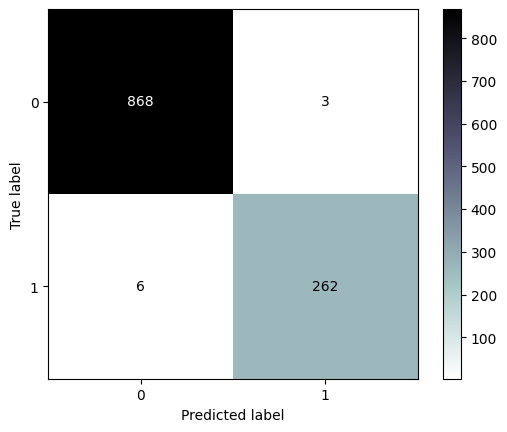

In [26]:
# Train SVM model
svm_model = SVC()
svm_model.fit(x_train, y_train)
# Evaluate SVM model
svm_metrics,y_pred_svm = evaluate_model(svm_model, x_test, y_test, model_name="SVM")

 EVALUATION METRICS (Random Forest) 

  ---------------------------------------------------------------- 

True Positives (TP): 243
True Negatives (TN): 870
False Positives (FP): 1
False Negatives (FN): 25

Accuracy   :  0.9771729587357331
Recall       :  0.9067164179104478
Precision    :  0.9959016393442623
F1-score     :  0.94921875
Specificity  :  0.9988518943742825
Miss Rate    :  0.09328358208955224
Mean Accuracy:  0.21905179982440737
Mean Square Error: 0.0228270412642669
  ---------------------------------------------------------------- 
 Classification Report: 
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       871
           1       1.00      0.91      0.95       268

    accuracy                           0.98      1139
   macro avg       0.98      0.95      0.97      1139
weighted avg       0.98      0.98      0.98      1139


  ---------------------------------------------------------------- 
 Confusion Matrix 


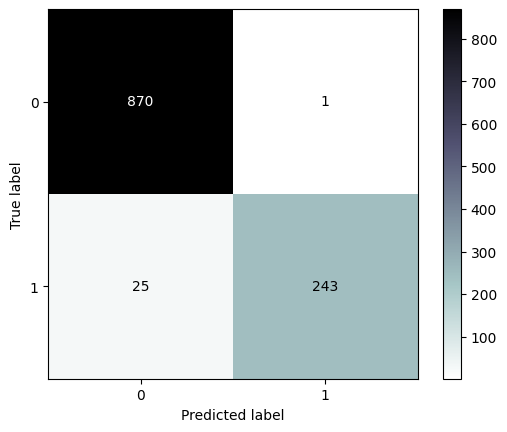

In [27]:
# Train Random Forest model
randomForest_model = RandomForestClassifier()
randomForest_model.fit(x_train, y_train)
# Evaluate Random Forest model
rf_metrics,y_pred_rf = evaluate_model(randomForest_model, x_test, y_test, model_name="Random Forest")

 EVALUATION METRICS (Decision Tree) 

  ---------------------------------------------------------------- 

True Positives (TP): 249
True Negatives (TN): 848
False Positives (FP): 23
False Negatives (FN): 19

Accuracy   :  0.9631255487269534
Recall       :  0.9291044776119403
Precision    :  0.9154411764705882
F1-score     :  0.9222222222222222
Specificity  :  0.9735935706084959
Miss Rate    :  0.0708955223880597
Mean Accuracy:  0.24078138718173836
Mean Square Error: 0.03687445127304653
  ---------------------------------------------------------------- 
 Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       871
           1       0.92      0.93      0.92       268

    accuracy                           0.96      1139
   macro avg       0.95      0.95      0.95      1139
weighted avg       0.96      0.96      0.96      1139


  ---------------------------------------------------------------- 
 Confusion Matrix

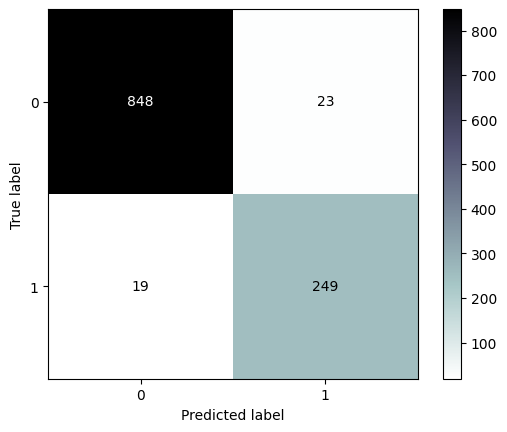

In [28]:
decisionTree_model = DecisionTreeClassifier()
decisionTree_model.fit(x_train, y_train)
dt_metrics,y_pred_dt = evaluate_model(decisionTree_model, x_test, y_test, model_name="Decision Tree")

 EVALUATION METRICS (Naive Bayes) 

  ---------------------------------------------------------------- 

True Positives (TP): 249
True Negatives (TN): 848
False Positives (FP): 23
False Negatives (FN): 19

Accuracy   :  0.9631255487269534
Recall       :  0.9291044776119403
Precision    :  0.9154411764705882
F1-score     :  0.9222222222222222
Specificity  :  0.9735935706084959
Miss Rate    :  0.0708955223880597
Mean Accuracy:  0.23968393327480245
Mean Square Error: 0.03687445127304653
  ---------------------------------------------------------------- 
 Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       871
           1       0.92      0.93      0.92       268

    accuracy                           0.96      1139
   macro avg       0.95      0.95      0.95      1139
weighted avg       0.96      0.96      0.96      1139


  ---------------------------------------------------------------- 
 Confusion Matrix 


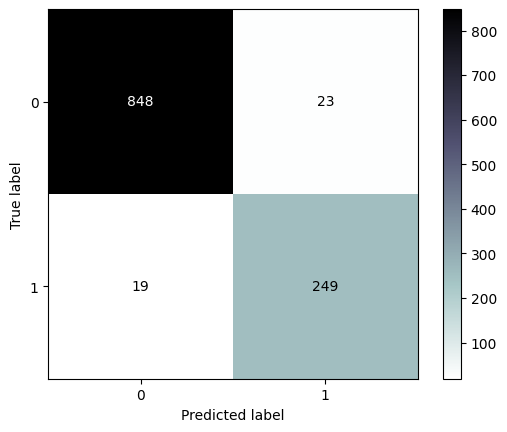

In [29]:
NaiveBayes_model = GaussianNB()
NaiveBayes_model.fit(x_train.toarray(), y_train)
nb_metrics,y_pred_nb = evaluate_model(decisionTree_model, x_test.toarray(), y_test, model_name="Naive Bayes")

In [30]:
svm_fpr, svm_tpr, threshold = roc_curve(y_test, y_pred_svm)
auc_svm = auc(svm_fpr, svm_tpr)
rf_fpr, rf_tpr, threshold = roc_curve(y_test, y_pred_rf)
auc_rfc = auc(rf_fpr, rf_tpr)
dt_fpr, dt_tpr, threshold = roc_curve(y_test, y_pred_dt)
auc_rfc = auc(dt_fpr, dt_tpr)
nb_fpr, nb_tpr, threshold = roc_curve(y_test, y_pred_nb)
auc_rfc = auc(nb_fpr, nb_tpr)

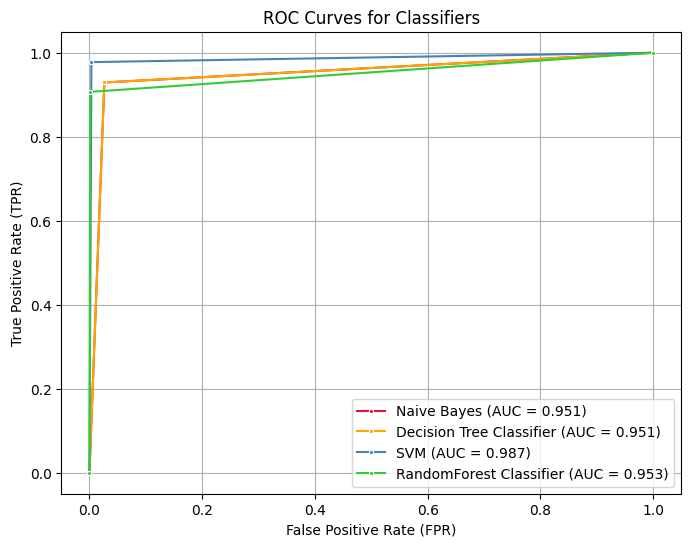

In [31]:
classifiers = {
    'Naive Bayes': (y_pred_nb, nb_fpr, nb_tpr),
    'Decision Tree Classifier': (y_pred_dt, dt_fpr, dt_tpr),
    'SVM': (y_pred_svm, svm_fpr, svm_tpr),
    'RandomForest Classifier': (y_pred_rf, rf_fpr, rf_tpr)
}

plt.figure(figsize=(8, 6), dpi=100)
colors=['crimson','orange','steelblue','limegreen']


for i, (clf_name, (y_pred, fpr, tpr)) in enumerate(classifiers.items()):
    auc_score = roc_auc_score(y_test, y_pred)  # Calculate AUC score using roc_auc_score
    sns.lineplot(x=fpr, y=tpr, marker='.', label=f'{clf_name} (AUC = {auc_score:.3f})', color=colors[i])

# Loop through classifiers and plot ROC curves
#for clf_name, (y_pred, fpr, tpr) in classifiers.items():
#    auc_score = roc_auc_score(y_test, y_pred)  # Calculate AUC score using roc_auc_score
#    sns.lineplot(x=fpr, y=tpr, marker='.', label=f'{clf_name} (AUC = {auc_score:.3f})')  # Use seaborn lineplot

# plot
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves for Classifiers')
plt.grid(True)
plt.legend()
plt.show()

In [32]:
# Extract metric names and values
metric_names = list(svm_metrics.keys())
svm_values = [svm_metrics[key] for key in metric_names if key != 'Classification Report']
rf_values = [rf_metrics[key] for key in metric_names if key != 'Classification Report']
dt_values = [dt_metrics[key] for key in metric_names if key != 'Classification Report']
nb_values = [nb_metrics[key] for key in metric_names if key != 'Classification Report']

length = len(metric_names)-1

length_svm = len(svm_values)
length_rf = len(rf_values)
length_dt = len(dt_values)
length_nb = len(nb_values)

print(length,length_svm,length_rf,length_dt,length_nb)
print()

8 8 8 8 8



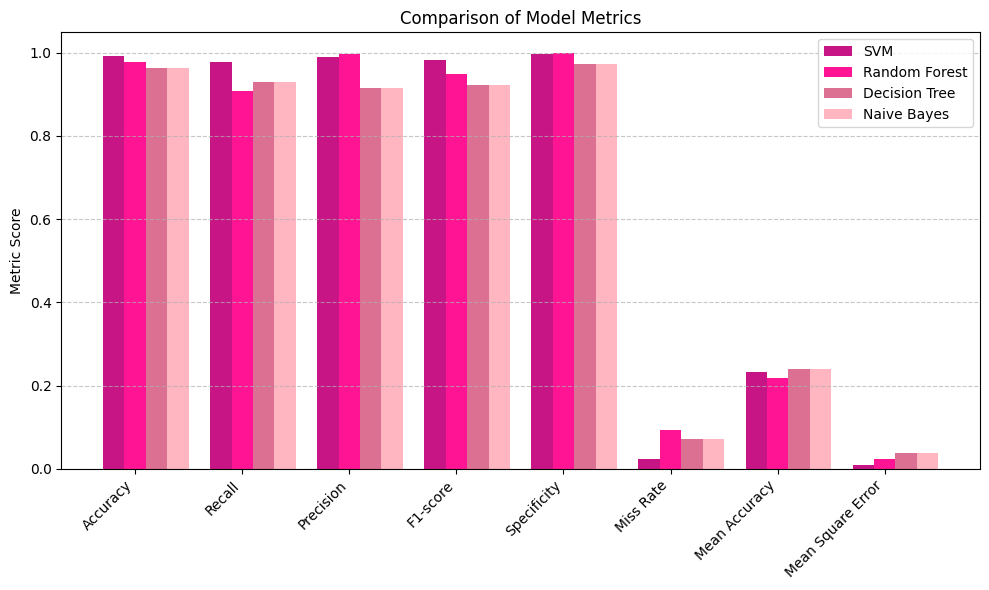

In [33]:
# Create a bar chart
plt.figure(figsize=(10, 6))
x = np.arange(length)
width = 0.2

# Plot comparison
#plt.bar(x, svm_values, width, label='SVM', color='darkolivegreen')
#plt.bar(x + width, rf_values, width, label='Random Forest', color='limegreen')
# Plot bars for each model
plt.bar(x - width, svm_values, width, label='SVM', color='mediumvioletred')
plt.bar(x, rf_values, width, label='Random Forest', color='deeppink')
plt.bar(x + width, dt_values, width, label='Decision Tree', color='palevioletred')
plt.bar(x + 2*width, nb_values, width, label='Naive Bayes', color='lightpink')


plt.xticks(x, [name for name in metric_names if name != 'Classification Report'], rotation=45, ha='right')
plt.ylabel('Metric Score')
plt.title('Comparison of Model Metrics')
plt.legend()

# Show the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Result:¶
This analysis evaluated four classification models (Naive Bayes, Decision Tree, SVM, and Random Forest) for their performance on a binary classification task. All models achieved high Recall, with SVM achieving the highest (0.992) followed by Random Forest (0.946), Naive Bayes and Decision Tree (both at 0.926).

In terms of AUC (Area Under the ROC Curve), SVM again emerged as the leader (0.994), followed by Random Forest (0.973 ) and lastly, Decision Tree and lastly Naive Bayest (both at 0.949)

Conclusion:
Based on the evaluation results, SVM classification model appears to be the best performing model overall, achieving the highest accuracy and AUC. However, the differences in performance between the models are relatively small

# **|| END OF NOTEBOOK ||**